In [1]:
# Import all required libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skms
from sklearn.tree import DecisionTreeClassifier
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.image as mpimg

In [2]:
# Util functions

DATA_DIR = '/home/nlukashina/education/bioinf/spring/fishbone_materials/Articles/censored_data/english/4.data' \
           '/sas_datasets/Assays/'


def best_features(x: np.ndarray, y: np.ndarray, n: int):
    n_features = x.shape[1]
    features_auc = dict(
        [(skmetrics.roc_auc_score(y, x[:, feature_idx]), feature_idx) for feature_idx in range(0, n_features)]
    )
    return [features_auc.pop(max(features_auc)) for i in range(0, n)]


def plot_roc(features: np.ndarray, x: np.ndarray, y: np.ndarray, labels: dict):
    for feature_idx in features:
        skmetrics.roc_auc_score(y, x[:, feature_idx])
        fpr, tpr, thresholds = skmetrics.roc_curve(y, x[:, feature_idx], pos_label=2)
        plt.plot(fpr, tpr)
        plt.title('ROC for feature ' + str(feature_idx) + ': ' + str(labels[feature_idx]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()


# create label column: 1 - young, 2 - old, 3 - very old
def label_age(age):
    if age > 75:
        return 3
    elif age < 65:
        return 1
    else:
        return 2

In [3]:
# Загрузим метаданные из кодбуков
metadata = pd.read_csv(DATA_DIR + 'labo_raw_metadata.csv')
metadata_by_num = metadata.set_index('Number')
metadata_by_name = metadata.set_index('Name')

In [4]:
# Загрузим данные, удалим из данных колонку с возрастом (она создается отдельно)
# Из данных удаляются все лишние (не числовые) колонки
# Пропуски в данных заполняются соответствующими средними

data = pd.read_csv(DATA_DIR + 'labo_raw.csv', header=None)
data.columns = metadata['Name'].values
data.drop([metadata_by_num.iloc[i]['Name'] for i in [0, 3, 4, 9, 10, 51]], inplace=True,
          axis=1)
ages = data.loc[:, 'X_AGEL'].copy()
data.drop(['X_AGEL'], inplace=True, axis=1)
data = data.apply(pd.to_numeric)
data.fillna(data.mean(), inplace=True) # TODO: check other strategies to fill gaps in data

y_column = ages.apply(lambda row: label_age(row))

In [6]:
# Эксперимент №1: old (65 - 75) vs young (< 65)
old_young_idxs = [idx for idx, label in enumerate(y_column.values) if label == 1 or label == 2]
x = data.values[old_young_idxs]
y = y_column.values[old_young_idxs]

{187: ('X_CLMIGM', 'BL Chlamydia pneumoniae antbdy IgM(titer'), 154: ('X_IL1RA', 'BL Interleukin-1RA ELISA ultra (pg/mL)'), 155: ('X_IL1B', 'BL Interleukin-1B via ELISA (pg/mL)'), 166: ('X_MCP1_B', 'BL Monocyte chemoattract protein-1(pg/mL'), 191: ('X_AGECML', 'BL AGE: Carboxymethyl-lysine (ng/mL)'), 192: ('X_ESRAGE', 'BL Endogenous secretory R for AGEs(ng/mL'), 64: ('X_CL', 'BL Cl- (mEq/L)'), 109: ('X_LS_CD4', 'BL Helper(CD4) as % total T lymphocytes'), 145: ('X_ADIPON', 'BL Adiponectin via RIA (µg/mL)'), 144: ('X_INSULN', 'BL Plasma insulin via RIA (mIU/L)')}


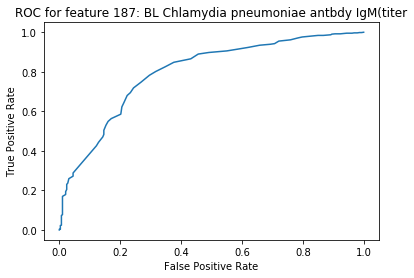

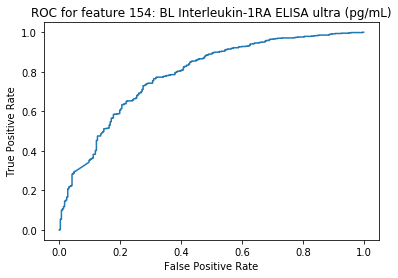

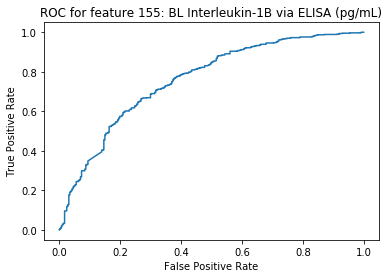

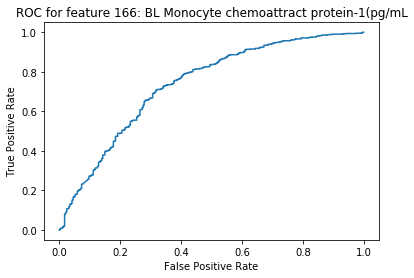

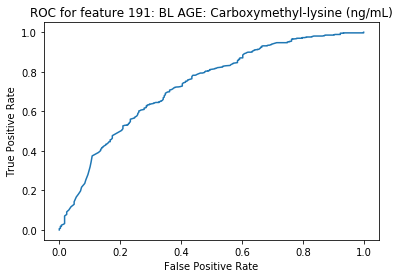

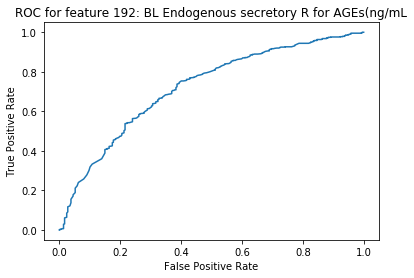

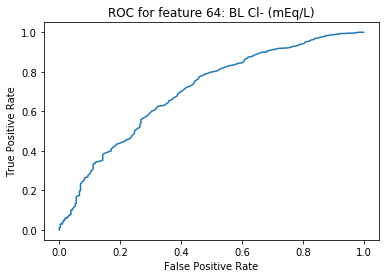

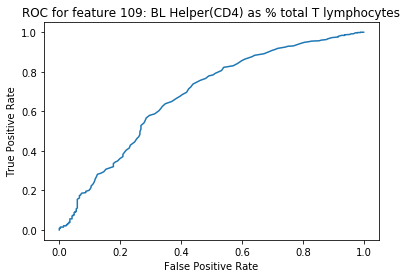

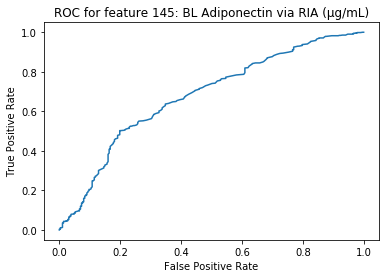

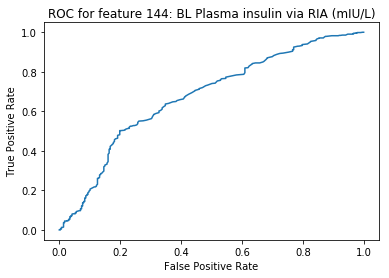

In [7]:
# Проанализируем придикаты: найдем 10 лучших по roc-auc
features = best_features(x, y, 10)
feature_properties, feature_labels = {}, {}
for idx in features:
    properties = metadata_by_num.iloc[idx + 1]
    feature_name, feature_label = properties['Name'], properties['Label']
    feature_properties[idx] = (feature_name, feature_label)
    feature_labels[idx] = feature_label
print(feature_properties)
plot_roc(features, x, y, feature_labels)

In [13]:
# Описания предикатов будут пополняться здесь:
# https://docs.google.com/spreadsheets/d/1kKtASyBAZdMpLkEx-7erJb0UIShsK5qOZujgAdXB4sk/edit?usp=sharing 
# Видно, что многие предикаты связаны с болезнями. Было бы интересно отдельно сделать, например, следующее:
# взять датасет с болезнями и выбрать старых и молодых людей с наименьшим числом болезней.
# Посмотреть на предикаты на такой выборке

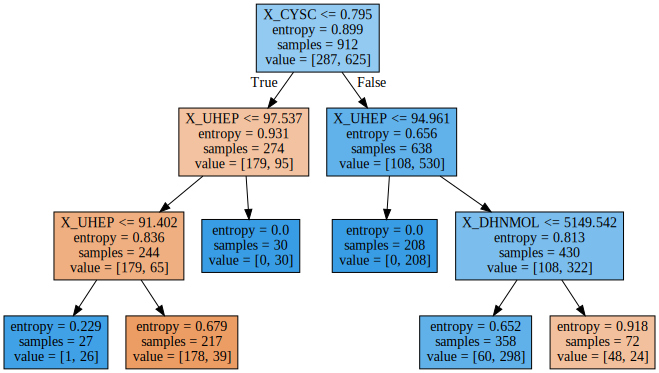

In [13]:
# Построим дерево на всех данных, чтобы посмотреть, что находится в узлах
clf: DecisionTreeClassifier = tree.DecisionTreeClassifier(max_depth=3, criterion="entropy")
clf: DecisionTreeClassifier = clf.fit(x, y)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=data.columns.values, filled = True))
display(SVG(graph.pipe(format='svg')))

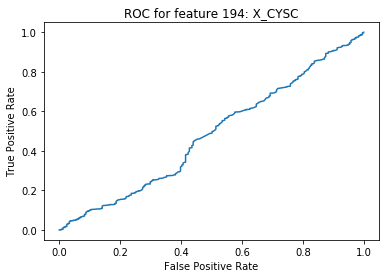

In [69]:
# Давайте посмотрим на roc-кривую для главного признака
sample_predicate_idx = metadata_by_name.loc['X_CYSC', :]['Number'] - 1
plot_roc([sample_predicate_idx], x, y, {sample_predicate_idx: 'X_CYSC'})
# Выглядит не очень впечатляюще..

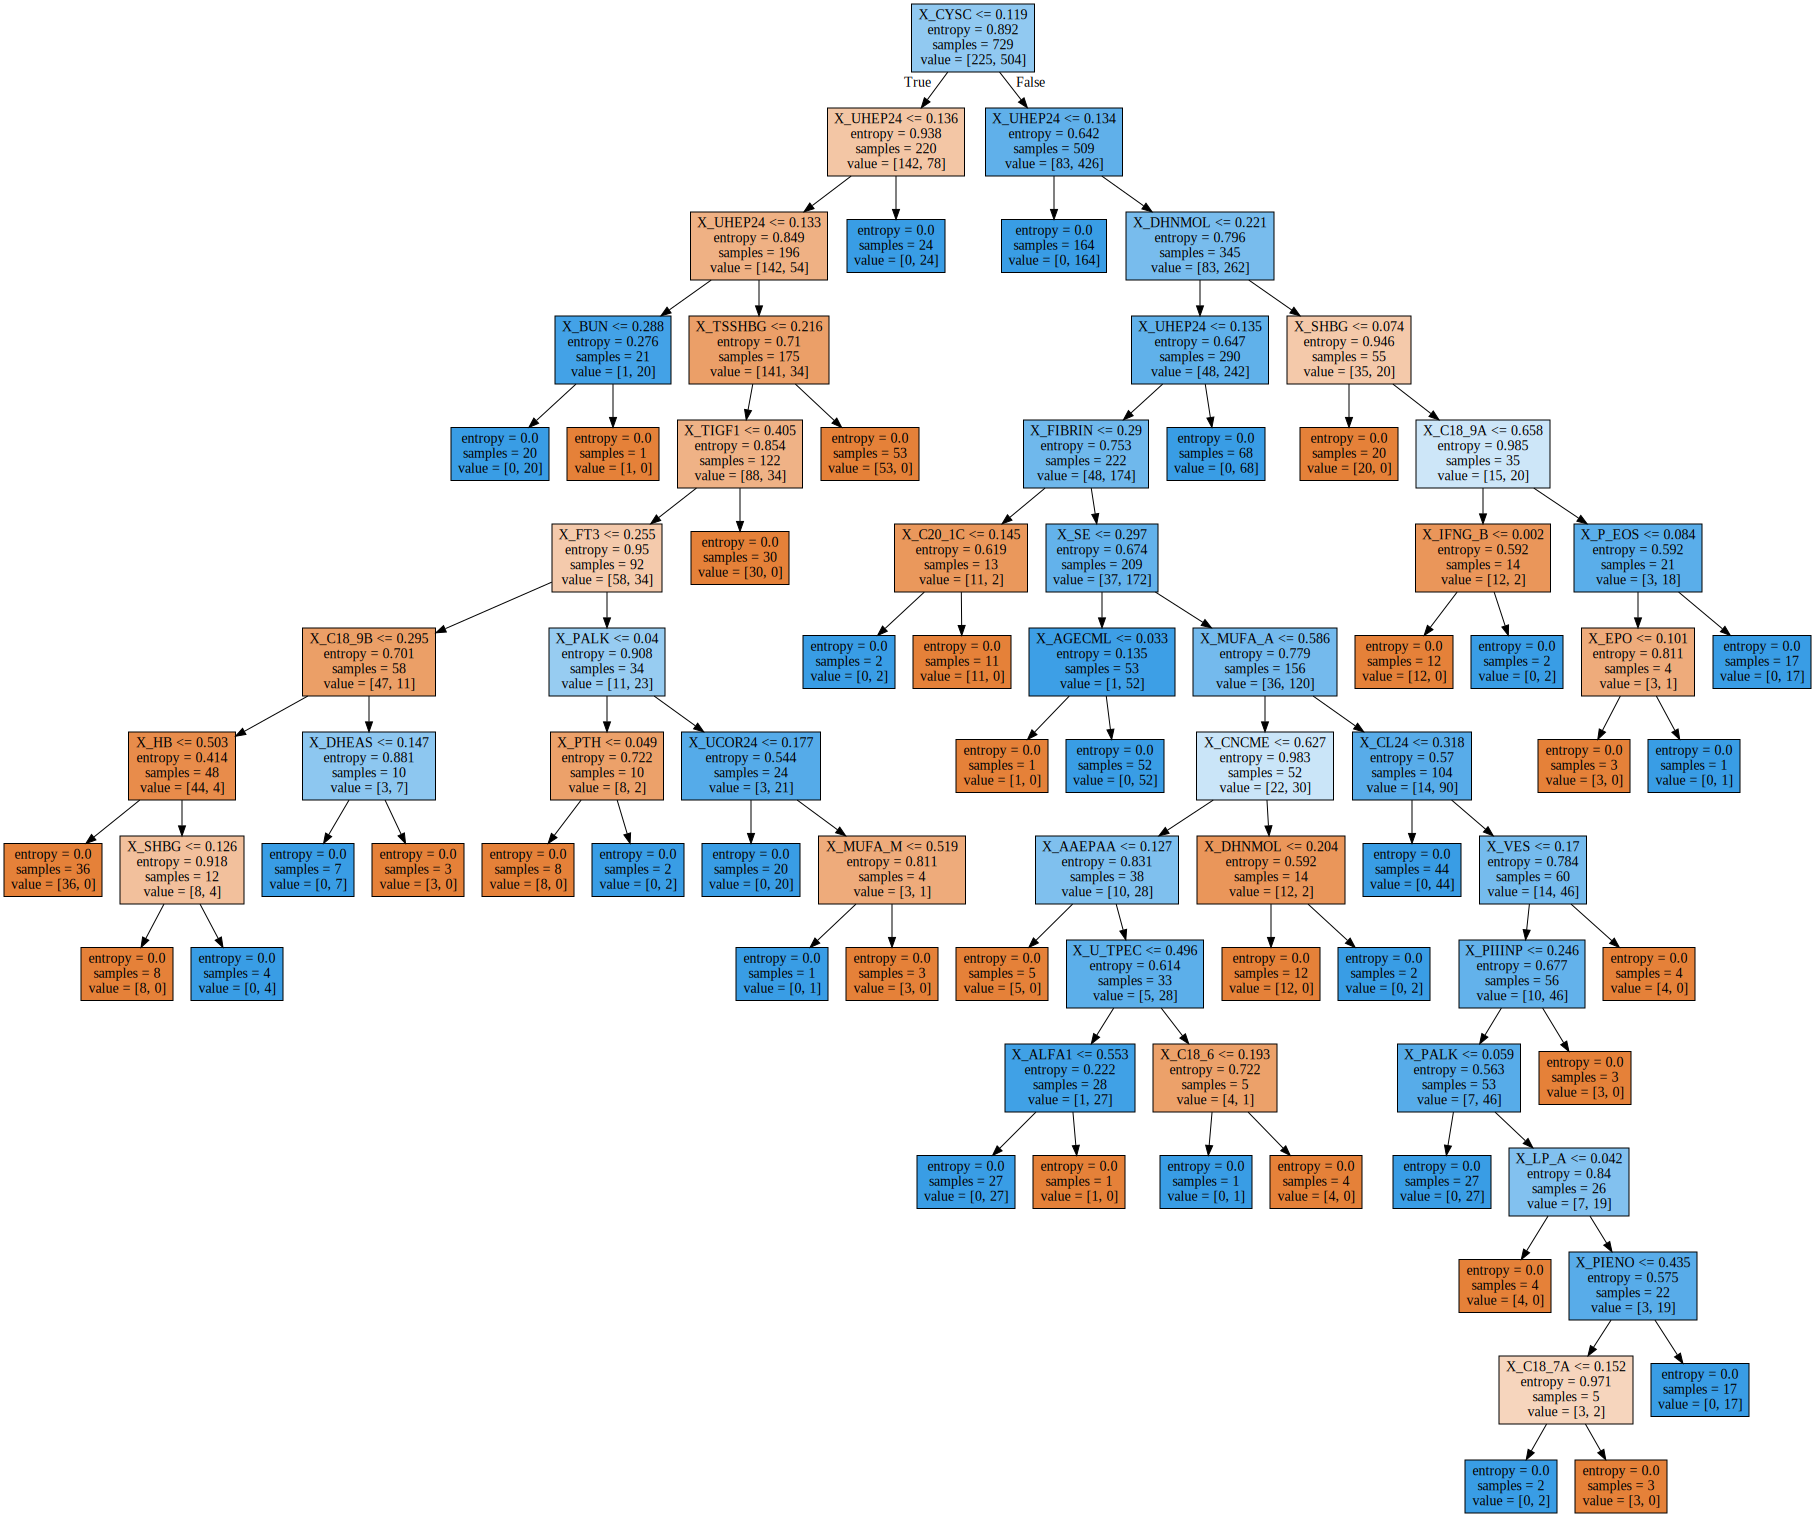

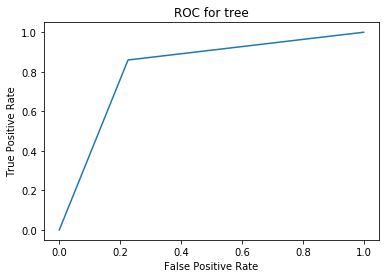

ROC AUC: 0.8168488403092509


In [14]:
# Попробуем сделать классификацию возраста на трейнтест разбивке. 
scaled_x = MinMaxScaler().fit_transform(x)
x_train, x_test, y_train, y_test = skms.train_test_split(scaled_x, y, test_size=0.2, shuffle=True)
clf: DecisionTreeClassifier = tree.DecisionTreeClassifier(criterion="entropy")
clf: DecisionTreeClassifier = clf.fit(x_train, y_train)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=data.columns.values, filled = True))
display(SVG(graph.pipe(format='svg')))

# Проверим точность классификатора
probs = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = skmetrics.roc_curve(y_test, probs, pos_label=2)
plt.plot(fpr, tpr)
plt.title('ROC for tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print('ROC AUC: ' + str(skmetrics.roc_auc_score(y_test, probs)))
# Выглядит неплохо..

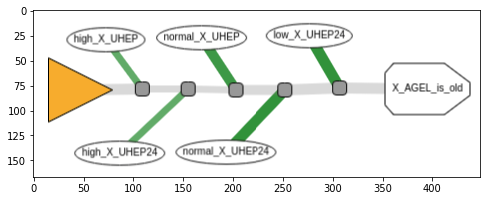

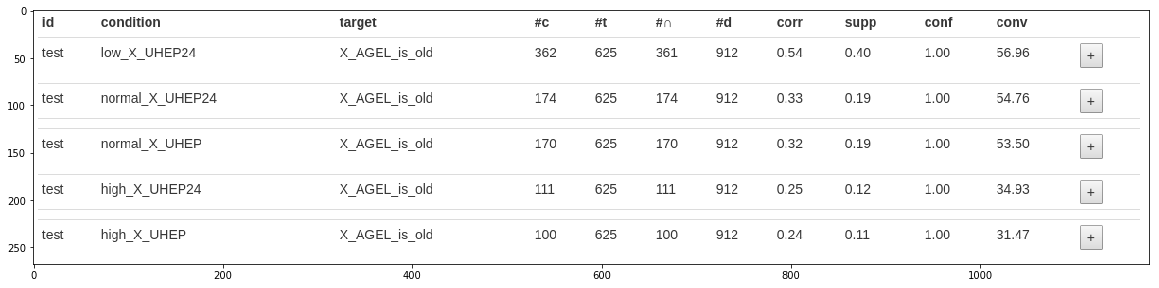

In [19]:
# Соответствующая фишбон-диаграмма без доп.требований по саппорту (старые, отрицание предикатов отключено)
plt.figure(figsize = (8, 8))
plt.imshow(mpimg.imread("old_no_restrictions.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("old_no_restrictions_table.png"), interpolation='nearest')

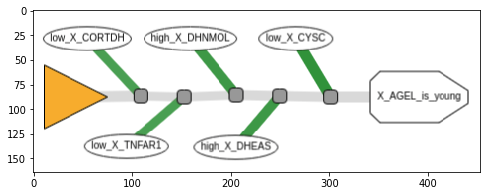

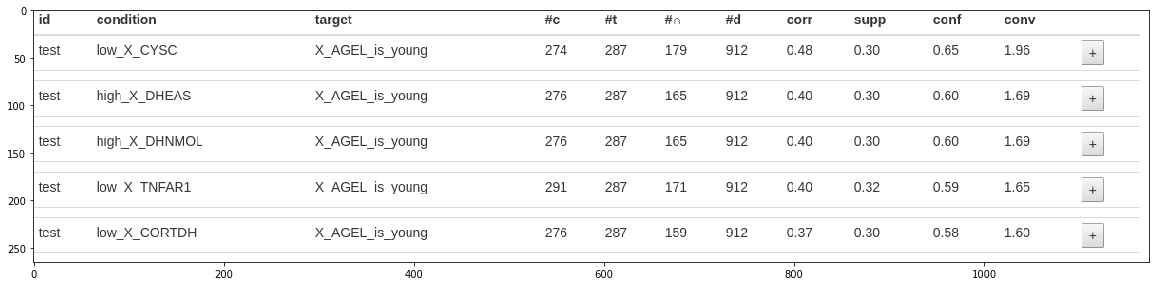

In [25]:
# Молодые (отрицание предикатов отключено)
plt.figure(figsize = (8, 8))
plt.imshow(mpimg.imread("young_no_restrictions.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("young_no_restrictions_table.png"), interpolation='nearest')
# Причем, эта же диаграмма сохраняется при саппорте >= 0.3

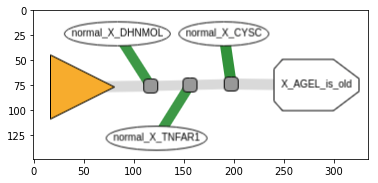

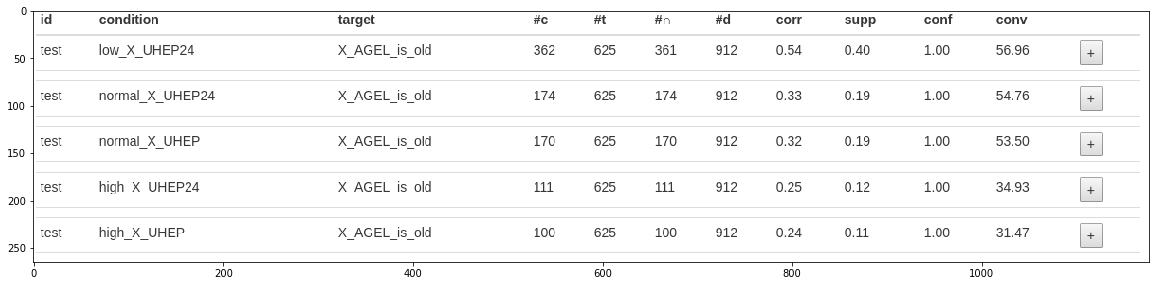

In [18]:
# Зададим ограничение на саппорт >= 0.4 для пожилых (отрицание предикатов отключено)
plt.figure(figsize = (6, 6))
plt.imshow(mpimg.imread("old_without_neg_sup_04_compl_1.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("old_support_04_table.png"), interpolation='nearest')

# Сравним предикаты со старыми:
# young ---- old
#low_cysc ---- normal_cysc
# high_dhnmol ---- normal_dhnmol
# low_tnfar1 ---- normal_tnfar1

# Подавляющее число значений "normal" в предикатах для пожилых людей может быть связано с тем, 
# что в датасете больше всех людей 70-79 лет
# т.е. именно их показатели являются "нормальными" для датасета

In [ ]:
# Видно, что предикаты X_CYSC и X_DHNMOL встречаются также в дереве.
# Посмотрим, что значат уровни normal:
# 0.8 <= X_CYSC <= 1.09 (в дереве: <= 0.805)
# 1132.78 <= X_DHNMOL <= 3779.908 (в дереве: X_DHNMOL <= 3442.919)

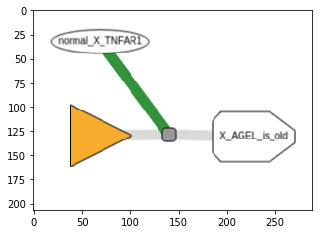

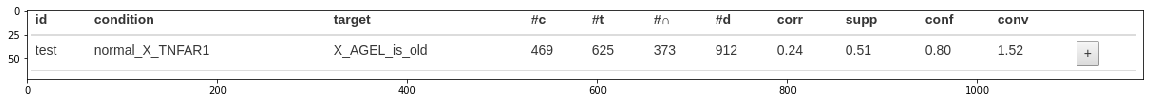

In [22]:
# Поднимем саппорт до 0.5 (при большем саппорте правил не наблюдается):
plt.figure(figsize = (5, 5))
plt.imshow(mpimg.imread("old_vs_young_support_05.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("old_support_05_table.png"), interpolation='nearest')

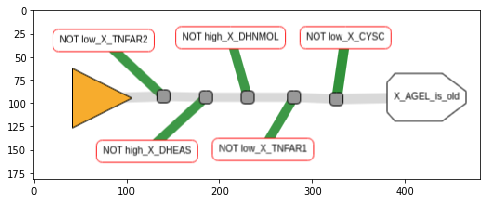

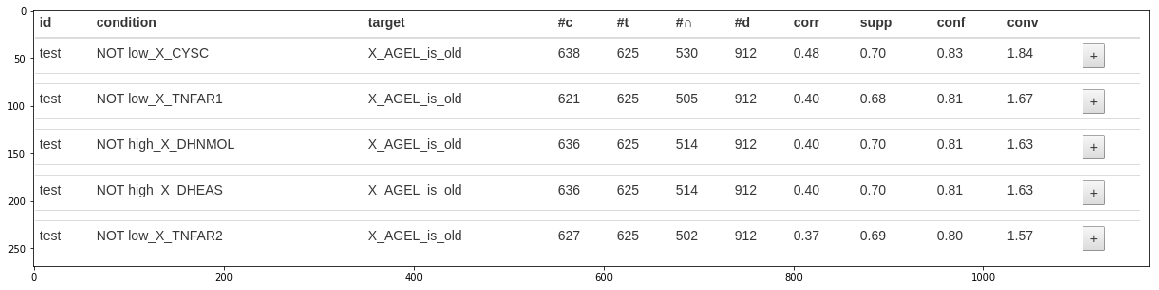

In [21]:
# С отрицательными предикатами, саппорт >= 0.5
plt.figure(figsize = (8, 8))
plt.imshow(mpimg.imread("old_with_not_support_04.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("old_with_not_support_04_table.png"), interpolation='nearest')

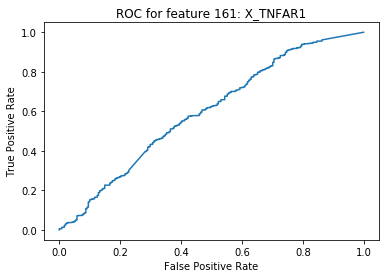

In [42]:
sample_predicate_idx = metadata_by_name.loc['X_TNFAR1', :]['Number'] - 1
plot_roc([sample_predicate_idx], x, y, {sample_predicate_idx: 'X_TNFAR1'})
# В дереве предикат отсутсвует

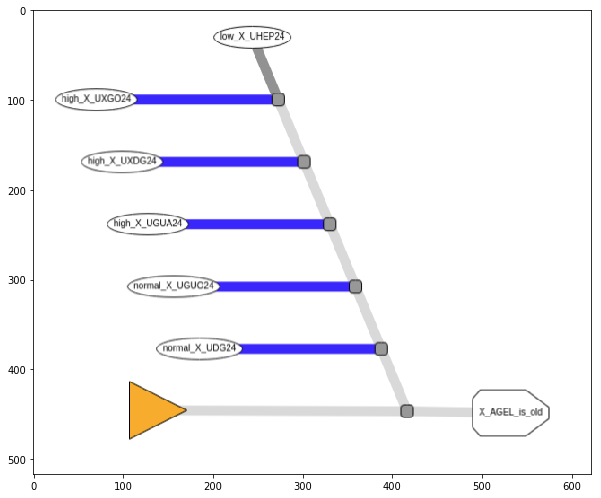

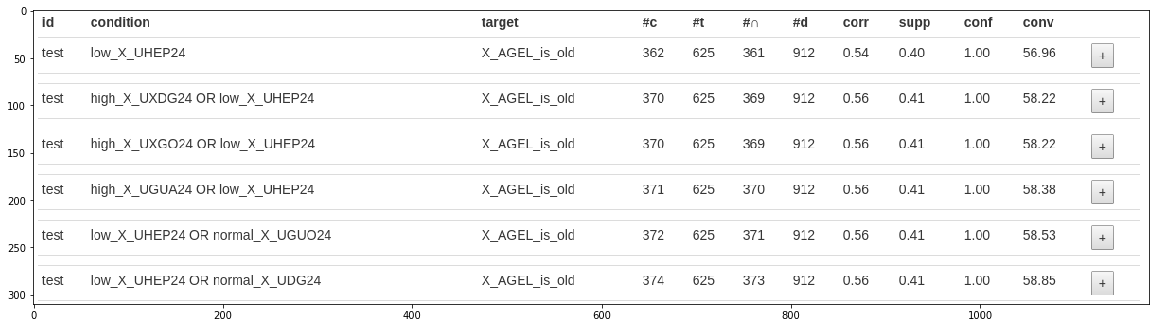

In [23]:
# Complexity 2, support >= 0.4 (отрицание отключено, с отрицанием предикаты те же)
plt.figure(figsize = (10, 10))
plt.imshow(mpimg.imread("old_vs_young_support_04_compl_2.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("old_support_04_compl_2_table.png"), interpolation='nearest')

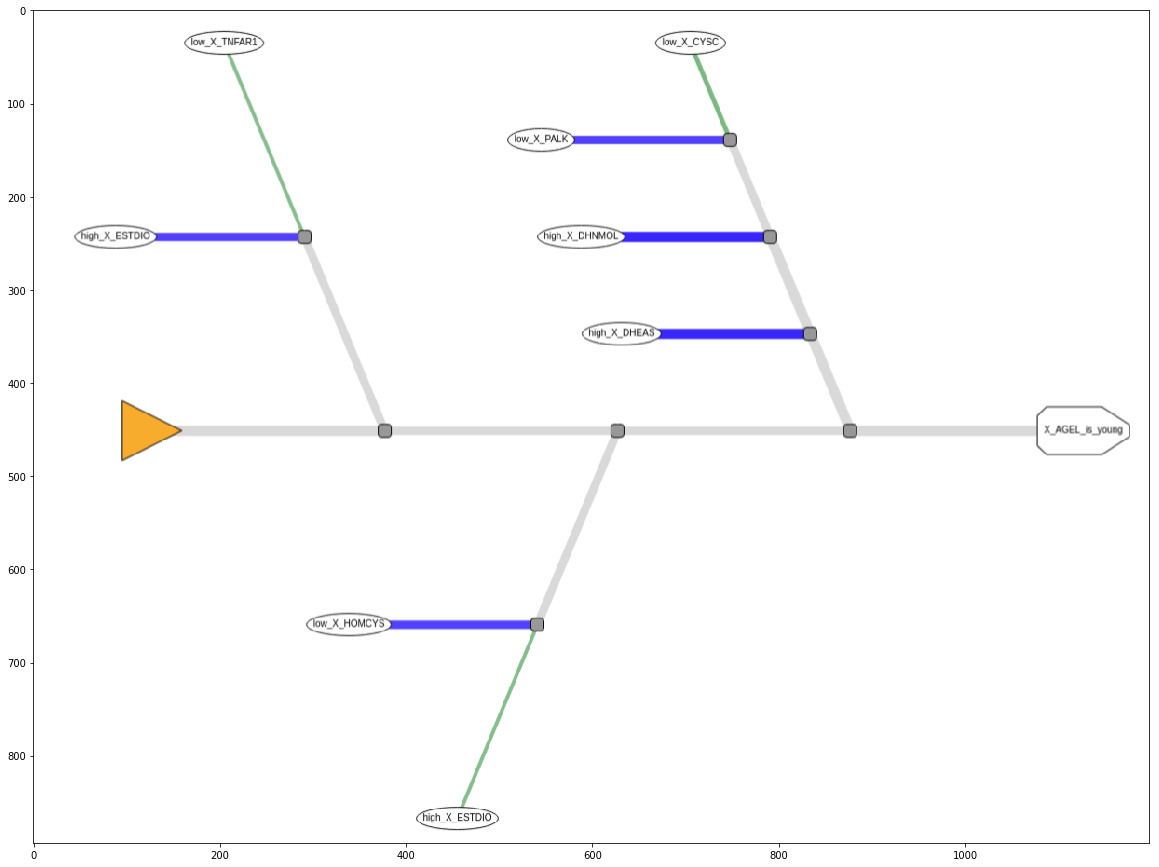

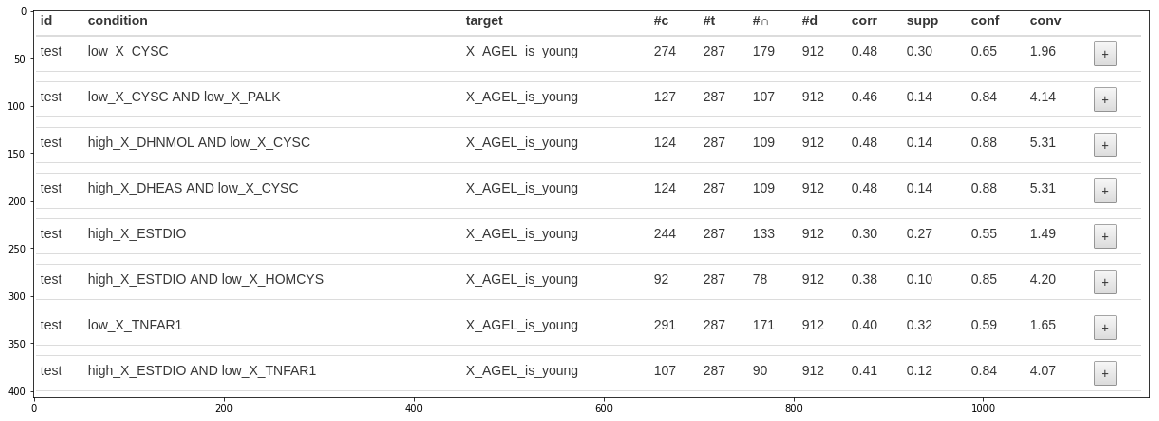

In [27]:
# Для молодых диграммы бОльшей сложности возможны только с низкий саппортом
# Complexity 2, support >= 0.1
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("young_support_01_compl_2.png"), interpolation='nearest')
plt.figure(figsize = (20, 20))
plt.imshow(mpimg.imread("young_support_01_compl_2_table.png"), interpolation='nearest')